In [1]:
#importing libraries
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model, save_model

import matplotlib.pyplot as plt
import seaborn as sb

## Reading and Processing Data

In [2]:
directory = "../dataset"

In [3]:
batch_size = 64
IMG_SIZE = (224, 224, 3)

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE[0], IMG_SIZE[1]),
    batch_size=batch_size,
    shuffle=True
    )

Found 1835 files belonging to 30 classes.
Using 1468 files for training.


In [5]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE[0], IMG_SIZE[1]),
    batch_size=batch_size,
    )

Found 1835 files belonging to 30 classes.
Using 367 files for validation.


In [6]:
class_names = (train_ds.class_names)

In [7]:
#saving class names
np.save("../artifacts/class_names.npy", class_names)

In [8]:
NUM_CLASSES = 30

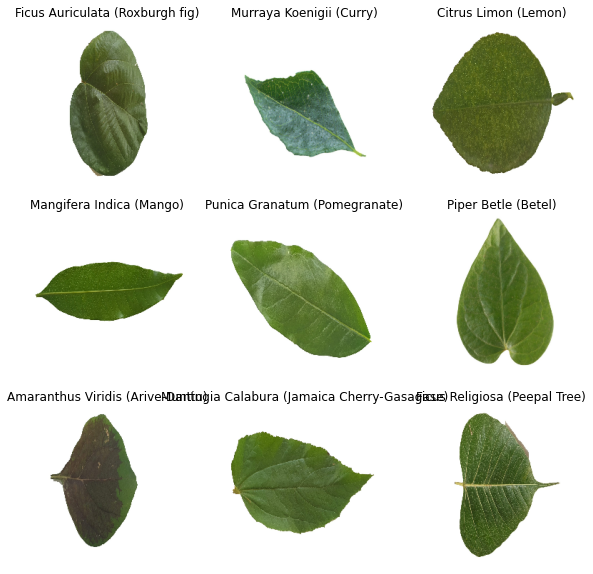

In [9]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

## Modelling

In [11]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential(
    [
        keras.layers.Rescaling(1./ 255),
        keras.layers.RandomFlip(),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomZoom(0.2,0.3)
    ]
)

## Using Pre-Trained ResNet50V2

In [12]:
pre_trained_layers = keras.applications.ResNet50V2(weights="imagenet", include_top=False,
           input_tensor=keras.Input(shape=IMG_SIZE))

In [13]:
#freezing the layers of ResNet
pre_trained_layers.trainable = False

In [14]:
pre_trained_layers.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 7, 7, 256)    589824      ['conv4_block6_2_pad[0][0]']     
          

                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 7, 7, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)  

In [15]:
model = keras.Sequential([
    data_augmentation, # data augmentations
    pre_trained_layers, # ResNet pre-trained layers
    keras.layers.Flatten(name="flatten"),
    keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output')
])

In [16]:
EPOCHS = 15
LR = 1e-3

In [17]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [18]:
# Callback -> Reduce Learning Rate on Plateau
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto',
                             min_delta=0.0001, cooldown=0, min_lr=0.00001)

In [19]:
history = model.fit(train_ds, epochs=EPOCHS, validation_data=validation_ds, callbacks=callback)

Epoch 1/15
23/23 [==============================] - 139s 6s/step - loss: 6.9961 - accuracy: 0.5320 - val_loss: 2.4124 - val_accuracy: 0.7956 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - 128s 6s/step - loss: 1.5529 - accuracy: 0.8522 - val_loss: 1.7490 - val_accuracy: 0.8747 - lr: 0.0010
Epoch 3/15
23/23 [==============================] - 137s 6s/step - loss: 0.8452 - accuracy: 0.9026 - val_loss: 1.2051 - val_accuracy: 0.8719 - lr: 0.0010
Epoch 4/15
23/23 [==============================] - 144s 6s/step - loss: 0.9469 - accuracy: 0.9128 - val_loss: 1.3441 - val_accuracy: 0.8937 - lr: 0.0010
Epoch 5/15
23/23 [==============================] - 134s 6s/step - loss: 0.8585 - accuracy: 0.9189 - val_loss: 1.3395 - val_accuracy: 0.9046 - lr: 0.0010
Epoch 6/15
23/23 [==============================] - ETA: 0s - loss: 1.0857 - accuracy: 0.9135
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
23/23 [==============================] - 126s 5s/step - los

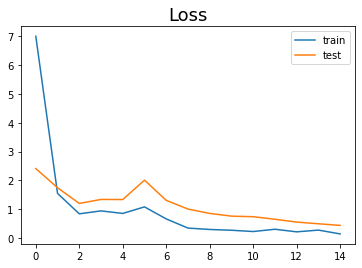

In [20]:
plt.title("Loss", fontdict={'fontsize':18})
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()

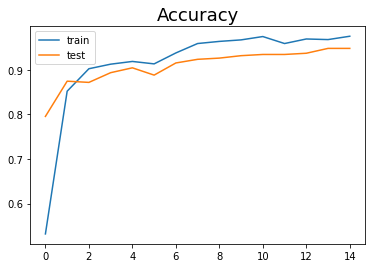

In [21]:
plt.title("Accuracy", fontdict={'fontsize':18})
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()

## Model Performance Analysis

In [47]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [23]:
Y_train = []
X_train = []

In [24]:
for data in train_ds:
    X_train.extend(data[0].numpy())
    Y_train.extend(data[1].numpy())

In [25]:
Y_train = np.array(Y_train)
X_train = np.array(X_train)

In [39]:
y_train_pred_prob = model.predict(X_train)
y_train_pred = [np.argmax(i) for i in y_train_pred_prob]

46/46 [==============================] - 81s 2s/step


In [41]:
y_train_pred_prob.shape

(1468, 30)

In [71]:
def roc_auc_curve(y_scores, y_true):
    # One hot encode the labels in order to plot them
    y_onehot = pd.get_dummies(y_true, columns=class_names)

    # Create an empty figure, and iteratively add new lines
    # every time we compute a new class
    fig = go.Figure()
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    for i in range(y_scores.shape[1]):
        y_true = y_onehot.iloc[:, i]
        y_score = y_scores[:, i]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_score = roc_auc_score(y_true, y_score)

        name = f"{class_names[i]} (AUC={auc_score:.2f})"
        fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

    fig.update_layout(
        title="ROC Curve",
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        yaxis=dict(scaleanchor="x", scaleratio=1),
        xaxis=dict(constrain='domain'),
        width=900, height=800
    )
    
    return fig

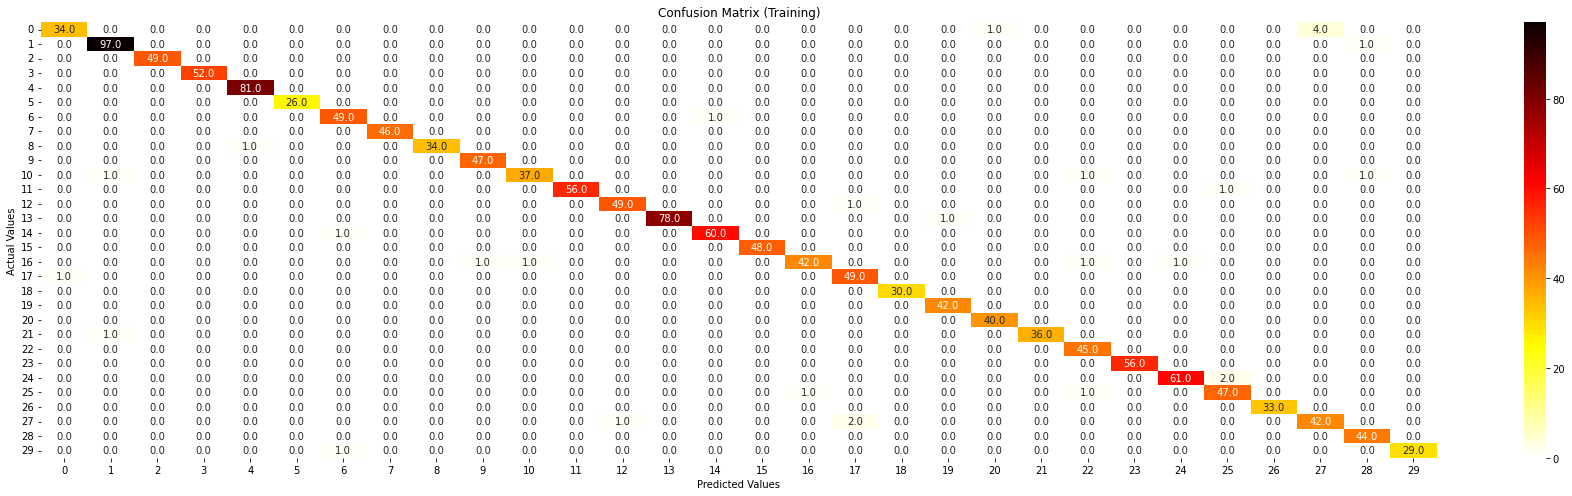

In [66]:
plt.figure(figsize=(25,7))
sb.heatmap(tf.math.confusion_matrix(labels=Y_train,predictions=y_train_pred),annot=True,fmt='.1f', cmap='hot_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix (Training)')
plt.tight_layout()
plt.show()

In [28]:
print("Classification Report for Training")
print(classification_report(Y_train, y_train_pred))

Classification Report for Training
              precision    recall  f1-score   support

           0       0.97      0.87      0.92        39
           1       0.98      0.99      0.98        98
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        52
           4       0.99      1.00      0.99        81
           5       1.00      1.00      1.00        26
           6       0.96      0.98      0.97        50
           7       1.00      1.00      1.00        46
           8       1.00      0.97      0.99        35
           9       0.98      1.00      0.99        47
          10       0.97      0.93      0.95        40
          11       1.00      0.98      0.99        57
          12       0.98      0.98      0.98        50
          13       1.00      0.99      0.99        79
          14       0.98      0.98      0.98        61
          15       1.00      1.00      1.00        48
          16       0.98      0.91      0.94   

In [72]:
roc_auc_curve(y_train_pred_prob, Y_train)

In [29]:
X_test = []
y_test = []

In [30]:
for data in validation_ds:
    X_test.extend(data[0].numpy())
    y_test.extend(data[1].numpy())

In [31]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [40]:
y_test_pred_prob = model.predict(X_test)
y_test_pred = [np.argmax(i) for i in y_test_pred_prob]

12/12 [==============================] - 22s 2s/step


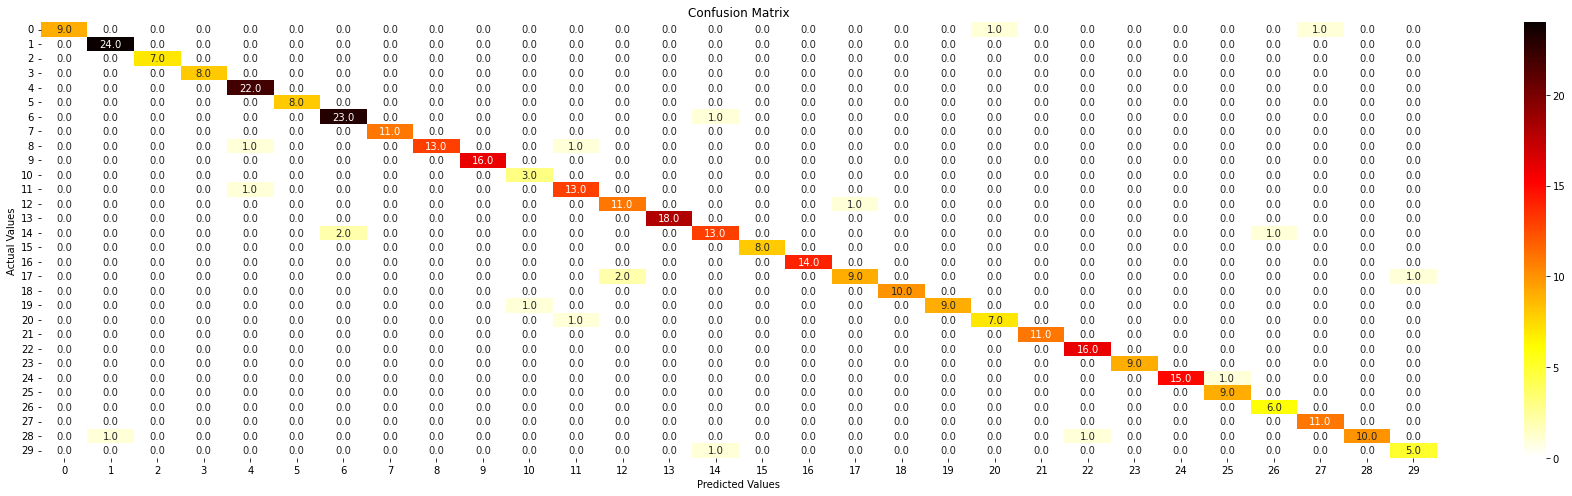

In [67]:
plt.figure(figsize=(25,7))
sb.heatmap(tf.math.confusion_matrix(labels=y_test,predictions=y_test_pred),annot=True,fmt='.1f', cmap='hot_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [35]:
print("Classification Report for Test")
print(classification_report(y_test, y_test_pred))

Classification Report for Test
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.96      1.00      0.98        24
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         8
           4       0.92      1.00      0.96        22
           5       1.00      1.00      1.00         8
           6       0.92      0.96      0.94        24
           7       1.00      1.00      1.00        11
           8       1.00      0.87      0.93        15
           9       1.00      1.00      1.00        16
          10       0.75      1.00      0.86         3
          11       0.87      0.93      0.90        14
          12       0.85      0.92      0.88        12
          13       1.00      1.00      1.00        18
          14       0.87      0.81      0.84        16
          15       1.00      1.00      1.00         8
          16       1.00      1.00      1.00       

In [73]:
roc_auc_curve(y_test_pred_prob, y_test)

## Saving Model

In [36]:
from tensorflow.keras.models import save_model

In [37]:
save_model(model, '../Model/model.h5')